In [1]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

import pickle
import tensorflow as tf

from tqdm.auto import tqdm  

# from typing import Sequence, Tuple, List
# from sklearn.preprocessing import StandardScaler

# from IPython.display import display, update_display, clear_output
# from tqdm.auto import tqdm         

In [2]:
save_dir   = Path("dfs training") 
ticker = 'AAPL'
ckpt_path = save_dir / f"best_{ticker}.weights.h5" 

In [3]:
#load model
model_path = Path("dfs training") / f"model_{ticker}.keras"
model = tf.keras.models.load_model(model_path)
model

C:\Users\Alienware\miniconda3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 12 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [4]:
# load dataset
save_dir = Path("dfs training")
spec = pickle.loads((save_dir / f"ds_test_{ticker}.pkl").read_bytes())

ds_test = tf.data.Dataset.load(
    str(save_dir / "ds_test_data"),     # Dir created by .save()
    element_spec=spec,
    compression="GZIP"
)
ds_test

<_LoadDataset element_spec=(TensorSpec(shape=(1, None, 300), dtype=tf.float32, name=None), TensorSpec(shape=(1, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.bool, name=None))>

In [5]:
###############################################################################
# 6. FINAL  EVALUATION  ON  THE  UNTOUCHED  TEST  SPLIT                       
###############################################################################

# 1) Reload champion weights
model.load_weights(ckpt_path)

# 2) Grab all stateful layers once
lstm_layers = [l for l in model.layers if hasattr(l, "reset_states")]

# 3) Metric accumulator
test_metric = tf.keras.metrics.RootMeanSquaredError()

# 4) Concrete length → makes tqdm show “n / total” instead of “?/”
N_test = sum(1 for _ in ds_test)      # cheap count
ds_test = ds_test.cache()             # allows second pass if needed

# 5) Iterate with progress bar
for X_day, y_day, new_day in tqdm(ds_test,
                                  total=N_test,
                                  unit="day",
                                  desc="Testing"):
    # flush hidden state at calendar boundary
    for l in lstm_layers: l.reset_states()

    # forward pass (no gradients) + metric update
    y_pred = model(X_day, training=False)
    test_metric.update_state(y_day, y_pred)

# 6) Final report
print(f"\nFINAL OUT-OF-SAMPLE TEST RMSE = {test_metric.result().numpy():.5f}")


Testing:   0%|          | 0/16 [00:00<?, ?day/s]


FINAL OUT-OF-SAMPLE TEST RMSE = 0.21821


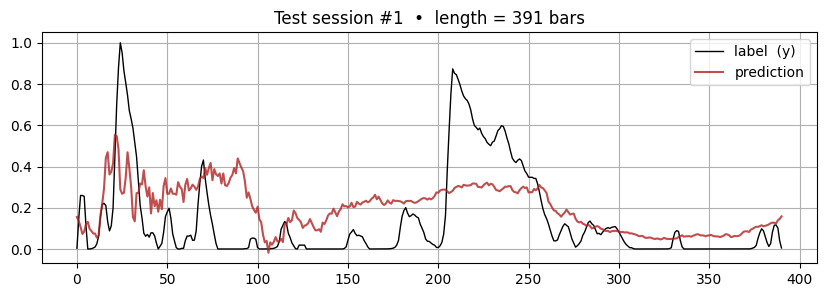

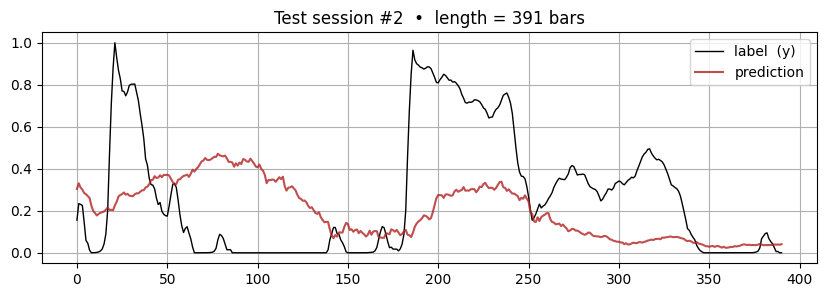

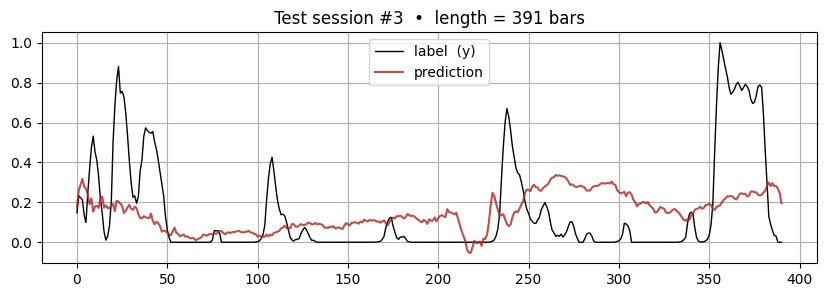

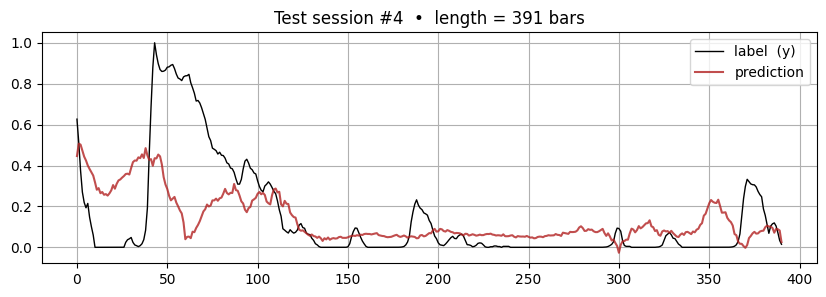

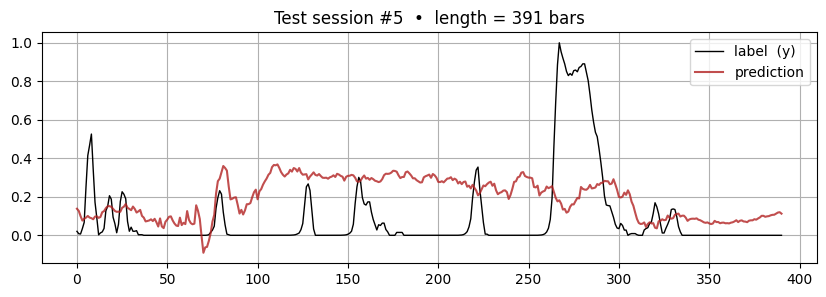

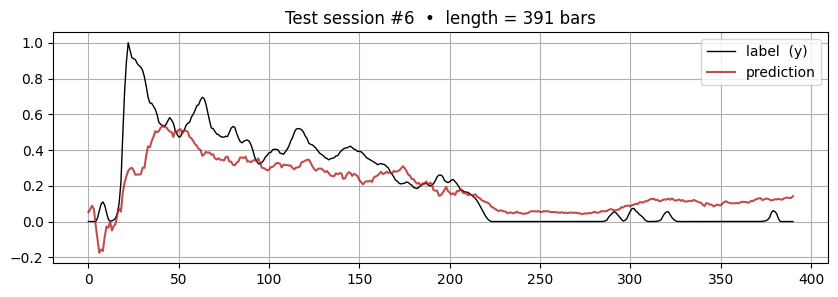

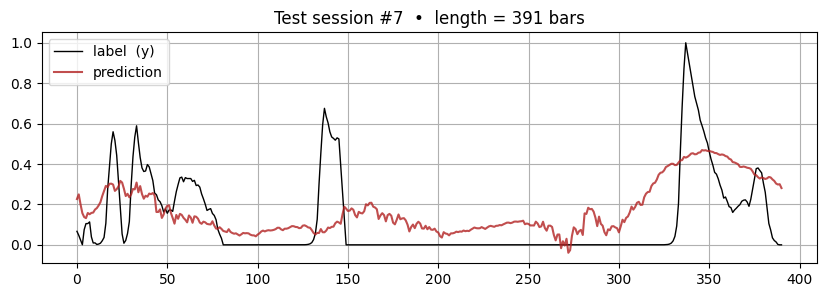

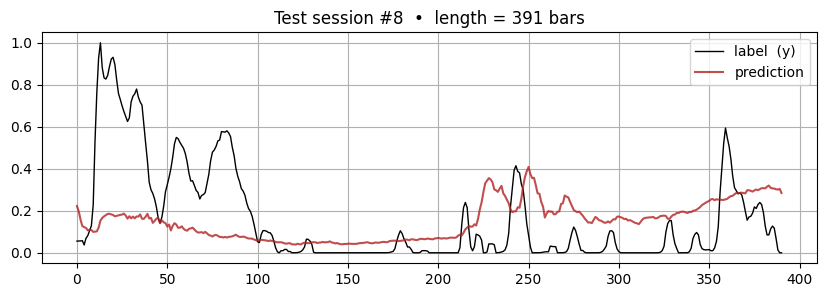

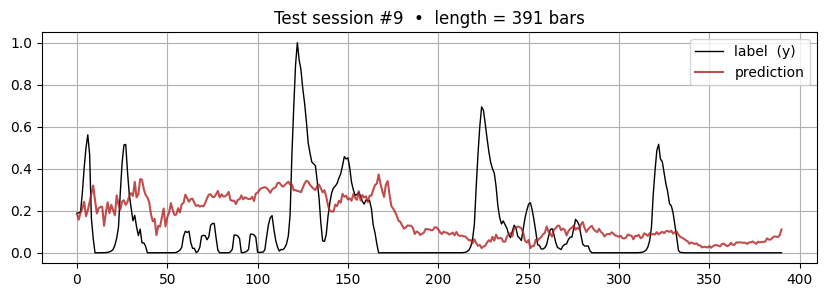

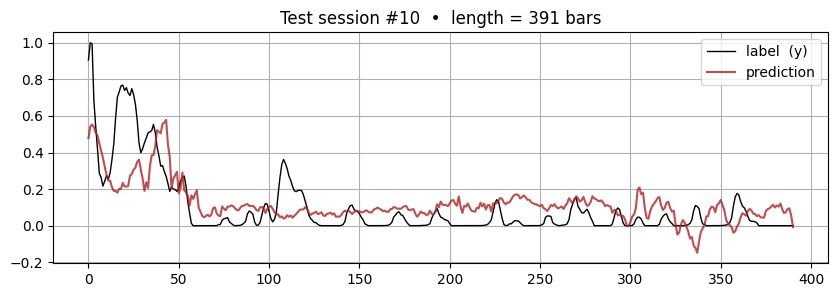

In [6]:
###############################################################################
# Visual sanity-check:  y_true  vs.  y_pred  for several test days
###############################################################################

# 1)  ── reload champion weights ──────────────────────────────────────
model.load_weights(ckpt_path)

# 2)  ── pick how many sessions you want to plot ──────────────────────
N_PLOTS = 10                              
plot_count = 0

# 3)  ── loop over test dataset (one element = one day) ───────────────
for X_day, y_day, new_day in ds_test:
    # (a) reset state at calendar boundary (always True in this dataset)
    for l in model.layers:
        if hasattr(l, "reset_states"):
            l.reset_states()

    # (b) forward pass → prediction
    y_pred = model(X_day, training=False)          # shape (1 , T , 1)
    y_pred = y_pred.numpy().squeeze()              # (T,)
    y_true = y_day.numpy().squeeze()               # (T,)

    # (c) quick line plot
    plt.figure(figsize=(10, 3))
    plt.plot(y_true, label="label  (y)",  color="black",  linewidth=1.0)
    plt.plot(y_pred, label="prediction",  color="firebrick", alpha=0.8)
    plt.title(f"Test session #{plot_count+1}  •  length = {len(y_true)} bars")
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_count += 1
    if plot_count >= N_PLOTS:
        break
